In [12]:
# 병렬구조

import functools
import operator
from datetime import datetime
from typing import Sequence, Annotated, Literal, Optional, Dict, List, Any
from typing_extensions import TypedDict

from dotenv import load_dotenv
from langchain.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate, load_prompt
from langchain_core.runnables import RunnableConfig
from langchain_core.tools.retriever import create_retriever_tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_teddynote.messages import stream_graph
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel
import uuid
import asyncio
import sys
import json

# --- 로컬 모듈 임포트 ---
from manse_8 import calculate_saju_tool
from pdf_retriever_saju import pdf_rag_chain, compression_retriever
from query_expansion_agent import get_query_expansion_node, get_query_expansion_agent

# --- 환경 변수 로드 ---
load_dotenv()

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

In [2]:
# --- LLM 및 기본 설정 ---
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# --- 1. Retriever 및 관련 도구 설정 ---
pdf_retriever = compression_retriever()
pdf_chain = pdf_rag_chain()

# retriever_tool = create_retriever_tool(
#     pdf_retriever,
#     "pdf_retriever",
#     "A tool for searching information related to Saju (Four Pillars of Destiny)",
#     document_prompt=PromptTemplate.from_template(
#         "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
#     ),
# )
retriever_tool = create_retriever_tool(
    pdf_retriever,
    "pdf_retriever",
    "A tool for searching information related to Saju (Four Pillars of Destiny)",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source></metadata></document>"
    ),
)
retriever_tools = [retriever_tool]

In [3]:
# --- 2. Agent 생성 ---

# Manse Tool Agent
manse_tools = [calculate_saju_tool]
manse_tool_agent = create_react_agent(llm, manse_tools)

# Retriever Tool Agent
base_prompt = load_prompt("prompt/saju-rag-promt_2.yaml")
saju_prompt = ChatPromptTemplate.from_messages([
    ("system", f"Today is {now}"),
    ("system", base_prompt.template),
    MessagesPlaceholder("messages"),
])

retriever_tool_agent = create_react_agent(llm, retriever_tools, prompt=saju_prompt).with_config({"tags": ["final_answer_agent"]})

# Web Search Tool Agent
tavily_tool = TavilySearch(max_results=2, include_domains=["namu.wiki", "wikipedia.org"])
duck_tool = DuckDuckGoSearchResults(max_results=2)
web_search_tools = [tavily_tool, duck_tool]
web_search_prompt = "사주 또는 사주 오행의 개념적 질문이나, 일상 질문이 들어오면, web search를 통해 답합니다."
web_tool_agent = create_react_agent(llm, tools=web_search_tools, prompt=web_search_prompt).with_config({"tags": ["final_answer_agent"]})

# General QA Tool Agent
@tool
def general_qa_tool(query: str) -> str:
    """
    일반적인 질문이나 상식적인 내용에 대해 답변합니다. 사주와 관련 없는 모든 질문에 사용할 수 있습니다.
    """
    google_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
    return google_llm.invoke(query)

general_qa_tools = [general_qa_tool]
general_qa_prompt = "일반적인 질문이나 상식적인 내용에 대해 답변합니다."
general_qa_agent = create_react_agent(llm, tools=general_qa_tools, prompt=general_qa_prompt).with_config({"tags": ["final_answer_agent"]})

# Query Expansion Agent
query_expansion_node = get_query_expansion_node()

In [4]:
# --- 사주 정보 구조 정의 ---
class BirthInfo(TypedDict):
    year: int
    month: int
    day: int
    hour: int
    minute: int
    is_male: bool
    is_leap_month: bool

class SajuResult(TypedDict):
    year_pillar: str
    month_pillar: str
    day_pillar: str
    hour_pillar: str
    day_master: str
    age: int
    korean_age: int
    element_strength: Optional[Dict[str, int]]
    ten_gods: Optional[Dict[str, List[str]]]
    great_fortunes: Optional[List[Dict[str, Any]]]
    yearly_fortunes: Optional[List[Dict[str, Any]]]
    useful_gods: Optional[List[str]]
    taboo_gods: Optional[List[str]]
    saju_analysis: Optional[str]


In [5]:
# --- 3. Agent 상태 및 노드 정의 ---

class AgentState(TypedDict):
    # 기본 LangGraph 요구사항
    question: str
    messages: Annotated[List[BaseMessage], operator.add]
    next: str
    final_answer: Optional[str]
    # 세션 관리
    session_id: str
    session_start_time: str
    current_time: str
    # 사주 시스템 핵심 정보
    birth_info: Optional[BirthInfo]
    saju_result: Optional[SajuResult]
    query_type: str  # "saju", "tarot", "general" 등
    # 에이전트 간 데이터 공유
    retrieved_docs: List[Dict[str, Any]]
    web_search_results: List[Dict[str, Any]]

# agent_node 함수 리팩토링: state 전체를 반환하도록 수정


In [6]:
def agent_node(state, agent, name):
    agent_response = agent.invoke(state)
    # 기존 메시지에 새 메시지 추가
    state["messages"] = state.get("messages", []) + [HumanMessage(content=agent_response["messages"][-1].content, name=name)]
    return state

def parse_birth_info_with_llm(user_input, llm):
    prompt = f"""
아래 문장에서 출생 정보를 추출해서 JSON 형태로 반환하세요.
필드: year, month, day, hour, minute, is_male, is_leap_month
예시 입력: "1996년 12월 13일 남자, 10시 30분 출생"
예시 출력: {{"year": 1996, "month": 12, "day": 13, "hour": 10, "minute": 30, "is_male": true, "is_leap_month": false}}

입력: {user_input}
"""
    result = llm.invoke(prompt)
    # LLM이 반환한 JSON 문자열을 파싱
    try:
        birth_info = json.loads(result.content)
        return birth_info
    except Exception as e:
        print("파싱 오류:", e)
        return None

In [7]:
from manse_8 import calculate_saju_tool

def manse_tool_agent_node(state):
    user_input = state["question"]
    birth_info = parse_birth_info_with_llm(user_input, llm)
    state["birth_info"] = birth_info
    saju_result = calculate_saju_tool(birth_info)
    state["saju_result"] = saju_result
    state["messages"].append(HumanMessage(content=f"사주 풀이 결과: {saju_result}", name="ManseTool"))
    return state

manse_tool_agent_node = functools.partial(agent_node, agent=manse_tool_agent, name="ManseTool")
retriever_tool_agent_node = functools.partial(agent_node, agent=retriever_tool_agent, name="RetrieverTool")
web_tool_agent_node = functools.partial(agent_node, agent=web_tool_agent, name="WebTool")
general_qa_agent_node = functools.partial(agent_node, agent=general_qa_agent, name="GeneralQA")

In [8]:
# --- 4. Supervisor Agent 정의 ---
members = ["SajuExpert", "WebTool", "GeneralQA"]
options_for_next = ["FINISH"] + members

class RouteResponse(BaseModel):
    next: Literal[*options_for_next]

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")


supervisor_system_prompt = (
    "오늘 날짜는 {now}입니다.\n"
    "당신은 다음과 같은 전문 에이전트들을 조율하는 Supervisor입니다: {members}.\n"
    "각 에이전트의 역할은 다음과 같습니다:\n"
    "- SajuExpert: 사주(생년월일/시간 등) 정보를 바탕으로 사주풀이, 운세 해석, 상세 분석을 담당합니다. "
        " 추가적인 질문으로 내일, 다음달 내년등 미래에 대한 운세를 물어볼때도 SajuExpert를 호출하세요. "
        " 이때 이전 사주구조를 사용해야 하며, 미래의 운세는 현재의 기준으로({now}) 나의 내일, 다음달, 내년 운세를 말합니다.\n"
        " 이때 특별한 요청이 있지 않는이상, 이전에 사용했던 사주구조, 천간지지, 오핸분석을 그대로 사용해야 합니다.\n"
    "- WebTool: 사주 개념, 오행 등 일반적/개념적 질문이나 일상 질문에 대해 웹 검색을 통해 답변합니다.\n"
    "- GeneralQA: 사주와 무관한 일반 상식, 과학, 프로그래밍 등 모든 질문에 답변합니다.\n\n"
    "당신의 임무는 사용자의 요청을 가장 적합한 에이전트에게 라우팅하는 것입니다.\n"
    "다음 기준을 따르세요:\n"
    "1. 사용자 입력에 생년월일, 출생시간 등 사주풀이에 필요한 정보가 포함되어 있거나,"
    " 추가적인 운세/사주풀이, 또는 내일, 다음달 내년등 미래에 대한 운세를(예: 내일 운세알려줘, 다음달 운세 알려줘 등등) 요청하면 SajuExpert를 호출하세요. 이때 현재의 기준으로({now}) 나의 내일, 다음달, 내년 운세를 말합니다.\n"
    " 이때 특별한 요청이 있지 않는이상, 이전에 사용했던 사주구조를 사용해야 합니다."
    "2. 사주에 대한 개념적/일반적 질문(예: '사주란 무엇인가요?')이나 일상 질문은 WebTool을 호출하세요.\n"
    "3. 사주와 전혀 관련 없는 질문은 GeneralQA를 호출하세요.\n"
    "4. **이전 대화(최근 assistant의 답변)가 SajuExpert(만세툴)에서 나온 것이고, 이번 질문이 그에 대한 추가 질문(예: '그럼 건강운은?', '재물운은?')이라면, 반드시 SajuExpert로 라우팅하세요.**\n"
    "5. 대화의 맥락을 고려하여, 사용자가 명시적으로 사주풀이를 요청하지 않아도, 직전 대화가 사주풀이였다면 추가 질문도 SajuExpert로 보내세요.\n"
    "에이전트가 답변을 마치면 FINISH로 응답하세요."
)

supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        ("system", "위 대화를 참고하여, 다음 중 누가 다음 행동을 해야 하는지 선택하세요: {options}"),
    ]
)

def supervisor_agent(state):
    supervisor_chain = (
        supervisor_prompt.partial(options=str(options_for_next), members=", ".join(members), now=now)
        | llm.with_structured_output(RouteResponse)
    )
    route_response = supervisor_chain.invoke(state)
    return {"next": route_response.next}

In [9]:
@tool
def saju_chat_tool(state):
    """
    사주에 대한 대화형 챗봇 답변을 생성합니다. 간단하게 답변해주세요.
    """
    # state에서 messages를 안전하게 가져오기
    messages = state.get("messages", [])
    response = "(사주 대화 결과: 추가 질문에 대한 답변)"
    # 기존 메시지 리스트에 새 메시지를 추가
    return {"messages": messages + [HumanMessage(content=response, name="SajuChat")]}

saju_chat_tools = [saju_chat_tool]
saju_chat_prompt = "사주 대화 결과를 참고하여 추가 질문에 대한 답변을 생성합니다. 예를들어, 내일의 운세, 내년의 운세등을 대화형식으로 답변합니다."
saju_chat_agent = create_react_agent(llm, saju_chat_tools, prompt=saju_chat_prompt)
saju_chat_node = functools.partial(agent_node, agent=saju_chat_agent, name="SajuChat")


# LLM 분기 프롬프트
branch_prompt = ChatPromptTemplate.from_messages([
    ("system", "다음 중 어디로 가야 할지 판단하세요: 'saju_chat' 또는 'retriever'.\n"
               "사주풀이에 추가 설명이 필요하면 'saju_chat', 생년월일을 입력받으면 'retriever'를 선택하세요.\n"
               "반드시 하나만 골라주세요.\n"),
    ("user", "질문: {user_input}\n"
             "manse 결과: {manse_result}\n"
             "어디로 가야 합니까? (saju_chat/retriever 중 하나만 답변)")
])

In [10]:
def llm_branch_decision(state):
    user_input = ""
    manse_result = ""
    # state에서 user_input, manse_result 추출 (구조에 따라 조정)
    if state.get("messages"):
        # messages가 리스트인지 문자열인지 확인
        if isinstance(state["messages"], list) and len(state["messages"]) > 0:
            # 첫 번째 메시지가 HumanMessage 객체인 경우
            if hasattr(state["messages"][0], 'content'):
                user_input = state["messages"][0].content
            else:
                user_input = str(state["messages"][0])
            
            # 마지막 메시지가 AIMessage 객체인 경우
            if hasattr(state["messages"][-1], 'content'):
                manse_result = state["messages"][-1].content
            else:
                manse_result = str(state["messages"][-1])
        else:
            # messages가 문자열인 경우
            user_input = str(state["messages"])
            manse_result = ""
    
    prompt = branch_prompt.format(user_input=user_input, manse_result=manse_result)
    # LLM 호출
    result = llm.invoke(prompt)
    # 결과에서 'saju_chat' 또는 'retriever'만 추출
    if "retriever" in result.content.lower():
        return "retriever"
    return "saju_chat"


In [11]:
def create_workflow_graph():
    """워크플로우 그래프 생성 (병렬 구조)"""
    saju_expert_workflow = StateGraph(AgentState)
    saju_expert_workflow.add_node("manse", manse_tool_agent_node)
    saju_expert_workflow.add_node("saju_chat", saju_chat_node)
    saju_expert_workflow.add_node("retriever", retriever_tool_agent_node)

    saju_expert_workflow.add_edge(START, "manse")
    saju_expert_workflow.add_conditional_edges(
        "manse",
        llm_branch_decision,
        {
            "saju_chat": "saju_chat",
            "retriever": "retriever"
        }
    )
    saju_expert_workflow.add_edge("saju_chat", END)
    saju_expert_workflow.add_edge("retriever", END)
    saju_expert_graph = saju_expert_workflow.compile(MemorySaver())  # 이 부분!
    
    # 메인 그래프 생성 (기존과 동일)
    workflow = StateGraph(AgentState)
    workflow.add_node("SajuExpert", saju_expert_graph)
    workflow.add_node("QueryExpansion", query_expansion_node)
    workflow.add_node("WebTool", web_tool_agent_node)
    workflow.add_node("GeneralQA", general_qa_agent_node)
    workflow.add_node("Supervisor", supervisor_agent)

    for member in members:
        workflow.add_edge(member, "Supervisor")

    conditional_map = {k: k for k in members}
    conditional_map["FINISH"] = END

    def get_next(state):
        return state["next"]

    workflow.add_conditional_edges("Supervisor", get_next, conditional_map)
    workflow.add_edge(START, "QueryExpansion")
    workflow.add_edge("QueryExpansion", "Supervisor")

    return workflow.compile(checkpointer=MemorySaver())

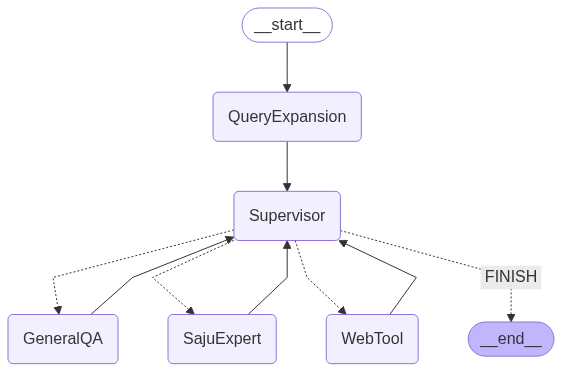

In [13]:
create_workflow_graph()

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
#config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 1})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="1995년 3월 28일 남자 12시 30분"
        )
    ],
}

# 그래프 실행
stream_graph(create_workflow_graph(), inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Could you provide a detailed birth chart analysis based on the Four Pillars of Destiny (Ba Zi) for a male born on March 28, 1995, at 12:30 PM? I am particularly interested in understanding the influences of the Heavenly Stems and Earthly Branches in his chart, as well as any insights regarding his personality, career prospects, and potential life challenges.1995년 3월 28일 남자 12시 30분
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
=== 사주팔자 ===
년주(年柱): 을해
월주(月柱): 기묘
일주(日柱): 무오
시주(時柱): 무오
일간(日干): 무
현재 나이: 30세 / 한국식 나이: 31세
기준 시점: 2025-07-06 10:16:06

=== 오행 강약 (8점 만점) ===
목: 2점
화: 2점
토: 3점
금: 0점
수: 1점

=== 십신 분석 ===
년주: 천간:정관, 지지:편재(70%), 지지:편관(30%)
월주: 천간:겁재, 지지:정관(100%)
일주: 지지:정인(70%), 지지:겁재(30%)
시주: 지지:정인(70%), 지지:겁재(30%)

=== 대운 (정밀 계산) ===
5세: 무인 (2000년

In [ ]:
# 그래프 생성
graph = create_workflow_graph()

# 스트리밍으로 실행하면서 state 변화 확인
print("=== 스트리밍 실행 (state 변화 확인) ===")

# state 변화를 추적하는 콜백 함수 정의
def state_callback(chunk_info):
    node = chunk_info["node"]
    content = chunk_info["content"]
    print(f"\n🔍 Node '{node}'에서 state 내용:")
    print(f"   Content: {content}")
    print("-" * 30)

# state 변화를 추적하면서 스트리밍 실행
stream_graph(graph, inputs, config, callback=state_callback)

# # 특정 노드만 필터링하여 스트리밍 실행
# print("=== 특정 노드만 스트리밍 실행 ===")
# 
# # 확인하고 싶은 노드들만 지정
# target_nodes = ["QueryExpansion", "Supervisor"]  # 원하는 노드명을 여기에 추가
# 
# # state 변화를 추적하는 콜백 함수 정의
# def state_callback(chunk_info):
#     node = chunk_info["node"]
#     content = chunk_info["content"]
#     print(f"\n🔍 Node '{node}'에서 state 내용:")
#     print(f"   Content: {content}")
#     print("-" * 30)
# 
# # 특정 노드만 필터링하여 스트리밍 실행
# stream_graph(graph, inputs, config, node_names=target_nodes, callback=state_callback)
# 
# # 또는 콜백 없이 특정 노드만 보기
# print("\n=== 콜백 없이 특정 노ㅠ드만 보기 ===")
# stream_graph(graph, inputs, config, node_names=target_nodes)



=== 스트리밍 실행 (state 변화 확인) ===

🔍 Node 'QueryExpansion'에서 state 내용:
   Content: 
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content: Could
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  you
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  provide
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  a
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  detailed
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  birth
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  chart
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  analysis
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  for
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  a
------------------------------

🔍 Node 'QueryExpansion'

In [ ]:
# state 변화를 추적하는 콜백 함수 정의
def state_callback(chunk_info):
    node = chunk_info["node"]
    content = chunk_info["content"]
    print(f"\n🔍 Node '{node}'에서 state 내용:")
    print(f"   Content: {content}")
    
    # birth_info가 state에 저장되어 있는지 확인
    if hasattr(content, 'birth_info'):
        print(f"   birth_info: {content.birth_info}")
    elif isinstance(content, dict) and 'birth_info' in content:
        print(f"   birth_info: {content['birth_info']}")
    else:
        print(f"   birth_info: 찾을 수 없음 (content 타입: {type(content)})")
    
    print("-" * 30)

# 콜백 함수를 사용하여 그래프 실행
print("=== state 변화 추적하면서 그래프 실행 ===")
stream_graph(graph, inputs, config, callback=state_callback)

=== state 변화 추적하면서 그래프 실행 ===

🔍 Node 'QueryExpansion'에서 state 내용:
   Content: 
   birth_info: 찾을 수 없음 (content 타입: <class 'str'>)
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content: Could
   birth_info: 찾을 수 없음 (content 타입: <class 'str'>)
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  you
   birth_info: 찾을 수 없음 (content 타입: <class 'str'>)
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  provide
   birth_info: 찾을 수 없음 (content 타입: <class 'str'>)
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  a
   birth_info: 찾을 수 없음 (content 타입: <class 'str'>)
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  detailed
   birth_info: 찾을 수 없음 (content 타입: <class 'str'>)
------------------------------

🔍 Node 'QueryExpansion'에서 state 내용:
   Content:  birth
   birth_info: 찾을 수 없음 (content 타입: <class 'str'>)
------------------------------

🔍 Node 'Que

In [22]:
class BirthInfo(TypedDict):
    year: int
    month: int
    day: int
    hour: int
    minute: int
    is_male: bool
    is_leap_month: bool

class SajuResult(TypedDict):
    year_pillar: str
    month_pillar: str
    day_pillar: str
    hour_pillar: str
    day_master: str
    age: int
    korean_age: int
    element_strength: Optional[Dict[str, int]]
    ten_gods: Optional[Dict[str, List[str]]]
    great_fortunes: Optional[List[Dict[str, Any]]]
    yearly_fortunes: Optional[List[Dict[str, Any]]]
    useful_gods: Optional[List[str]]
    taboo_gods: Optional[List[str]]
    saju_analysis: Optional[str]

# --- 3. Agent 상태 및 노드 정의 ---

class AgentState(TypedDict):
    # 기본 LangGraph 요구사항
    question: str
    messages: Annotated[List[BaseMessage], operator.add]
    next: str
    final_answer: Optional[str]
    # 세션 관리
    session_id: str
    session_start_time: str
    current_time: str
    # 사주 시스템 핵심 정보
    birth_info: Optional[BirthInfo]
    saju_result: Optional[SajuResult]
    query_type: str  # "saju", "tarot", "general" 등
    # 에이전트 간 데이터 공유
    retrieved_docs: List[Dict[str, Any]]
    web_search_results: List[Dict[str, Any]]

In [36]:
def parse_birth_info_with_llm(user_input, llm):
    prompt = f"""
    아래 문장에서 출생 정보를 추출해서 반드시 JSON만 반환하세요. (설명, 문장, 코드블록, 따옴표 없이 JSON만!)
    필드: year, month, day, hour, minute, is_male, is_leap_month
    예시 입력: "1996년 12월 13일 남자, 10시 30분 출생"
    예시 출력: {{"year": 1996, "month": 12, "day": 13, "hour": 10, "minute": 30, "is_male": true, "is_leap_month": false}}

    입력: {user_input}
    """
    result = llm.invoke(prompt)
    print("LLM 원본 응답:", result.content)  # 이 줄 추가!
    try:
        birth_info = json.loads(result.content)
        return birth_info
    except Exception as e:
        print("파싱 오류:", e)
        return None

In [37]:
user_input = "1995년 3월 28일 남자 12시 30분"
birth_info = parse_birth_info_with_llm(user_input, llm)


LLM 원본 응답: {"year": 1995, "month": 3, "day": 28, "hour": 12, "minute": 30, "is_male": true, "is_leap_month": false}


In [38]:
def manse_tool_agent_node(state):
    user_input = state["question"]
    birth_info = parse_birth_info_with_llm(user_input, llm)
    state["birth_info"] = birth_info   # ✅ 여기서 state에 저장!
    return state

In [35]:
manse_tool_agent_node({"question": "1995년 3월 28일 남자 12시 30분"})

LLM 원본 응답: {"year": 1995, "month": 3, "day": 28, "hour": 12, "minute": 30, "is_male": true, "is_leap_month": false}


{'question': '1995년 3월 28일 남자 12시 30분',
 'birth_info': {'year': 1995,
  'month': 3,
  'day': 28,
  'hour': 12,
  'minute': 30,
  'is_male': True,
  'is_leap_month': False}}